In [1]:
#Loading libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import pyhf
from pyhf.contrib.viz import brazil
import scipy
from scipy import stats
import uproot3
import uproot
import math
import awkward as ak
import pickle
import csv
from importlib import reload

import Utilities.Constants as Constants
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print("Successful!")

Successful!


In [2]:
Params_pyhf = {"Stats_only":False,
               "Use_flat_sys":False,
               "Use_part_only":True,
               "Num_bins_for_calc":4,
               "Use_toys":True,
               "Num_toys":100,
               "Load_lepton_hists":True,
               "Load_pi0_hists":False,
               "Flat_bkg_overlay_frac":0.5,
               "Flat_bkg_dirt_frac":1.0,
               "Flat_bkg_EXT_frac":0.0,
               "Flat_sig_detvar":0.2, #This is very conservative, could be fed in per mass point from signal detvar script
               "Signal_flux_error":0.3, #This comes from the KDAR flux uncertainty.
               "Overlay_detvar_frac":0.5,
               "Load_single_r1_file": True}

Functions.pyhf_params(Params_pyhf)

Using fully evaluated systematic uncertainty for background. Dirt will still be 100%.
Using fully evaluated systematic uncertainty for signal. Using 30.0% flux error.


In [3]:
hist_dict_run1, hist_dict_run3, theta_dict = Functions.Load_pyhf_files("logit_ultimate_benchmark_data_test.root", Params_pyhf, HNL_masses = [245])

No missing histograms in Run1
thetas are:
{245: 0.0004}
Done


## Loading in Uncertainties

In [4]:
def Calculate_total_uncertainty(Params, hist_dict, zero_bins_errs): #Takes the dictionary of all root files
    TOT_BKG_ERR_dict, TOT_SIGNAL_ERR_dict = {}, {}
    BKG_STAT_ERR_dict, SIGNAL_STAT_ERR_dict = {}, {}
    BKG_SHAPESYS_ERR_dict, SIGNAL_SHAPESYS_ERR_dict = {}, {}
    SIGNAL_NORMSYS_ERR_dict = {} #No normsys for this because currently background contributions are added together
    bkg_sample_names = ['bkg_overlay','bkg_EXT','bkg_dirt']
    overlay_sys_names = ["ppfx_uncertainty","Genie_uncertainty","Reinteraction_uncertainty","overlay_DetVar_uncertainty"]
    for HNL_mass in hist_dict:
        bkg_stat_err_dict, bkg_sys_err_dict = {}, {} #Clean for each mass point
        for name in bkg_sample_names:
            bkg_stat_err_dict[name]=hist_dict[HNL_mass][name].errors() #Load in stat error from error saved in hist
        sig_stat_err = hist_dict[HNL_mass]['signal'].errors()
        if Params["Stats_only"] == True: #Set all systematic errors to zero
            for name in bkg_sample_names:
                bkg_sys_err_dict[name] = np.zeros_like(hist_dict[HNL_mass][name].errors())
            sig_sys_err =  np.zeros_like(hist_dict[HNL_mass]['signal'].errors())
        elif Params["Use_flat_sys"] == True:
            for name in bkg_sample_names:
                bkg_sys_err_dict[name] = hist_dict[HNL_mass][name].values()*Params["Flat_"+name+"_frac"]
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*Params["Signal_flux_error"]
            sig_detvar_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_detvar"]
            sig_sys_err = np.sqrt(sig_flux_err**2 + sig_detvar_err**2)
        elif Params["Use_flat_sys"] == False: #This is using the fully evaluated uncertainties
            overlay_sys_dict = {}
            for sys in overlay_sys_names:
                overlay_sys_dict[sys] = hist_dict[HNL_mass][sys].values()
            bkg_sys_err_dict['bkg_overlay'] = Functions.add_all_errors_dict(overlay_sys_dict)
            bkg_sys_err_dict['bkg_EXT'] = np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors())
            bkg_sys_err_dict['bkg_dirt'] = hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_bkg_dirt_frac"]
            
            sig_detvar_err = hist_dict[HNL_mass]["signal_DetVar_uncertainty"].values()
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*Params["Signal_flux_error"]
            sig_sys_err = Functions.add_all_errors([sig_detvar_err,sig_flux_err])
            
        #Evaluating final stat+sys errors    
        bkg_stat_plus_sys_dict={}
        for name in bkg_sample_names:
            bkg_stat_plus_sys_dict[name]=Functions.add_all_errors([bkg_stat_err_dict[name],bkg_sys_err_dict[name],zero_bins_errs[HNL_mass][name]]) 
        
        total_bkg_err = Functions.add_all_errors_dict(bkg_stat_plus_sys_dict) #Now adding the errors of overlay, EXT and dirt in quadrature
        total_sig_err = Functions.add_all_errors([sig_stat_err,sig_sys_err])
        
        TOT_BKG_ERR_dict[HNL_mass] = total_bkg_err
        TOT_SIGNAL_ERR_dict[HNL_mass] = total_sig_err
        
        BKG_STAT_ERR_dict[HNL_mass] = Functions.add_all_errors_dict(bkg_stat_err_dict)
        BKG_SHAPESYS_ERR_dict[HNL_mass] = Functions.add_all_errors_dict(bkg_sys_err_dict)
        SIGNAL_STAT_ERR_dict[HNL_mass] = sig_stat_err
        SIGNAL_SHAPESYS_ERR_dict[HNL_mass] = sig_detvar_err
    TOT_ERR_DICT = {}
    TOT_ERR_DICT["TOT_BKG_ERR"], TOT_ERR_DICT["TOT_SIGNAL_ERR"] = TOT_BKG_ERR_dict, TOT_SIGNAL_ERR_dict
    TOT_ERR_DICT["BKG_STAT"], TOT_ERR_DICT["BKG_SHAPESYS"] = BKG_STAT_ERR_dict, BKG_SHAPESYS_ERR_dict
    TOT_ERR_DICT["SIGNAL_STAT"], TOT_ERR_DICT["SIGNAL_SHAPESYS"] = SIGNAL_STAT_ERR_dict, SIGNAL_SHAPESYS_ERR_dict
    # return TOT_BKG_ERR_dict, TOT_SIGNAL_ERR_dict
    return TOT_ERR_DICT
    

#Want TOTAL_BKG_ERR_DICT, STAT_BKG_ERR_DICT, SHAPESYS_BKG_ERR_DICT, where the shapesys also contains the dirt and overlay flat norm errors.
# TOTAL_SIGNAL_ERR_DICT, STAT_SIGNAL_ERR_DICT, SHAPESYS_SIGNAL_ERR_DICT, NORM_SIGNAL_ERR_DICT

def Uncertainty_breakdown(Params, hist_dict, bkg_reweight_err_dict=None, bkg_detvar_dict=None, sig_detvar_dict=None): #Takes the dictionary of all root files
    BKG_ERR_dict, SIGNAL_ERR_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_stat_err_list = [hist_dict[HNL_mass]['bkg_overlay'].errors(), 
                             hist_dict[HNL_mass]['bkg_EXT'].errors(), 
                             hist_dict[HNL_mass]['bkg_dirt'].errors()]
        sig_stat_err = hist_dict[HNL_mass]['signal'].errors()
        print("Signal stat error:")
        print(sig_stat_err)
        if Params["Stats_only"] == True:
        #As default the errors saved in the files are stat errors, this will change once I properly calculate them
            bkg_err_list = bkg_stat_err_list
            sig_err = sig_stat_err
        elif Params["Use_flat_sys_bkg"] == True:
            zero_bins = []
            for i,val in enumerate(hist_dict[HNL_mass]['bkg_overlay'].values()):
                if val == 0:
                    zero_bins.append(i)
                    print(f"{HNL_mass} last bin 0, setting error to 2.0")
            if len(zero_bins) != 0:
                bkg_sys_err_list = [hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Flat_overlay_bkg_frac"] + np.ones_like(hist_dict[HNL_mass]['bkg_overlay'].values())*2.0, #This is horrible need to rewrite 
                                    np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                    hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]]
            else:    
                bkg_sys_err_list = [hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Flat_overlay_bkg_frac"], 
                                    np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                    hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]]
            bkg_err_list = [Functions.add_all_errors([bkg_stat_err_list[0],bkg_sys_err_list[0]]), #adding the sys and stat error in quadrature for each bkg type
                            Functions.add_all_errors([bkg_stat_err_list[1],bkg_sys_err_list[1]]),
                            Functions.add_all_errors([bkg_stat_err_list[2],bkg_sys_err_list[2]])]
        elif Params["Use_flat_sys_bkg"] == False:
            ppfx_unc = hist_dict[HNL_mass]["ppfx_uncertainty"].values()
            genie_unc = hist_dict[HNL_mass]["Genie_uncertainty"].values()
            reint_unc = hist_dict[HNL_mass]["Reinteraction_uncertainty"].values()
            # detvar_unc = bkg_detvar_dict[HNL_mass]["Total_DetVar_uncertainty"].values() #Don't know what this looks like yet, as I haven't made
            detvar_unc = hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Overlay_detvar_frac"] #Just setting as flat. Too much variation in samples
            tot_overlay_sys = Functions.add_all_errors([ppfx_unc, genie_unc, reint_unc, detvar_unc])
            bkg_sys_err_list = [tot_overlay_sys, 
                                np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]] #Don't have reweight or DetVar samples for dirt
            bkg_err_list = [Functions.add_all_errors([bkg_stat_err_list[0],bkg_sys_err_list[0]]), #adding the sys and stat error in quadrature for each bkg type
                            Functions.add_all_errors([bkg_stat_err_list[1],bkg_sys_err_list[1]]),
                            Functions.add_all_errors([bkg_stat_err_list[2],bkg_sys_err_list[2]])]
            bkg_stat_err_total = Functions.add_all_errors([bkg_stat_err_list[0],bkg_stat_err_list[1],bkg_stat_err_list[2]])
            print("bkg stat error:")
            print(bkg_stat_err_total)
            print("bkg flux error:")
            print(ppfx_unc)
            print("bkg genie error:")
            print(genie_unc)
            print("bkg reint error:")
            print(reint_unc)
            
        if (Params["Stats_only"] == False) and (Params["Use_flat_sys_signal"] == True):
            zero_bins = []
            for i,val in enumerate(hist_dict[HNL_mass]['signal'].values()):
                if val == 0:
                    zero_bins.append(i)
                    print(f"{HNL_mass} signal last bin 0, setting error to 2.0")
            if len(zero_bins) != 0:
                sig_sys_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_frac"]+2.0
            else:
                sig_sys_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_frac"]
            sig_err = Functions.add_all_errors([sig_stat_err,sig_sys_err])
        if (Params["Stats_only"] == False) and (Params["Use_flat_sys_signal"] == False):
            sig_detvar_err = sig_detvar_dict[HNL_mass]["Total_DetVar_uncertainty"].values()
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*Params["Signal_flux_error"]
            sig_err = Functions.add_all_errors([sig_stat_err,sig_detvar_err,sig_flux_err]) #Adding stat, detvar and flux errors in quadrature
        total_bkg_err = Functions.add_all_errors(bkg_err_list) #Now adding the errors of overlay, EXT and dirt in quadrature
        BKG_ERR_dict[HNL_mass] = total_bkg_err
        SIGNAL_ERR_dict[HNL_mass] = sig_err
        print("Total bkg error:")
        print(total_bkg_err)
        print("Total signal error:")
        print(sig_err)
    return BKG_ERR_dict, SIGNAL_ERR_dict
    
def Add_bkg_hists_make_signal(hist_dict):
    BKG_dict, SIGNAL_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_hists = [hist_dict[HNL_mass]['bkg_EXT'], hist_dict[HNL_mass]['bkg_overlay'], hist_dict[HNL_mass]['bkg_dirt']]
        
        total_bkg = Functions.add_hists_vals(bkg_hists)
        BKG_dict[HNL_mass] = total_bkg
        SIGNAL_dict[HNL_mass] = hist_dict[HNL_mass]['signal'].values()
 
    return BKG_dict, SIGNAL_dict


In [5]:
reload(Functions)
zero_bins_errors_run1 = Functions.make_zero_bin_unc(hist_dict_run1, Constants.run1_POT_scaling_dict)
zero_bins_errors_run3 = Functions.make_zero_bin_unc(hist_dict_run3, Constants.run3_POT_scaling_dict)

TOT_R1_ERR = Calculate_total_uncertainty(Params_pyhf, hist_dict_run1, zero_bins_errors_run1)
TOT_R3_ERR = Calculate_total_uncertainty(Params_pyhf, hist_dict_run3, zero_bins_errors_run3)

R1_BKG, R1_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run1)
R3_BKG, R3_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run3)

R1_output = Functions.Make_into_lists(Params_pyhf, R1_BKG, R1_SIGNAL, TOT_R1_ERR)
R3_output = Functions.Make_into_lists(Params_pyhf, R3_BKG, R3_SIGNAL, TOT_R3_ERR)

list_input_dicts = [R1_output, R3_output]

Total_dict_both = Functions.Create_final_appended_runs_dict(list_input_dicts)
Total_dict_run1 = Functions.Create_final_appended_runs_dict([R1_output])
Total_dict_run3 = Functions.Create_final_appended_runs_dict([R3_output])

dict_keys([245])
dict_keys([245])
dict_keys([245])


In [6]:
def create_stat_unc(Total_dict):
    sig_stat, bkg_stat = {}, {}
    for HNL_mass in Total_dict:
        sig_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['SIGNAL_STAT']),np.array(Total_dict[HNL_mass]['SIGNAL_dict'])))
        bkg_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['BKG_STAT']),np.array(Total_dict[HNL_mass]['BKG_dict'])))
    return sig_stat, bkg_stat

sig_stat, bkg_stat = create_stat_unc(Total_dict_both)


In [7]:
def create_model_dict_same(Total_dict, debug=False): #Creating a model where the uncertainties are all enveloped in one shapesys modifier
    model_dict = {}
    
    for HNL_mass in Total_dict:
        if(debug):print(HNL_mass)
        model_dict[HNL_mass] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": Total_dict[HNL_mass]["SIGNAL_dict"],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_siguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]["TOT_SIGNAL_ERR"]}
              ]
            },
            {
              "name": "background",
              "data": Total_dict[HNL_mass]["BKG_dict"],
              "modifiers": [
                {"name": "uncorr_bkguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]["TOT_BKG_ERR"]}
              ]
            }
          ]
        }
      ]
    }
    )
    return model_dict

def create_model_dict_split(Total_dict, debug=False): #Creating a model where the different types of uncertainties are split into different modifiers
    model_dict = {}
    sig_norm = {"hi": 1.0+Params_pyhf["Signal_flux_error"], "lo": 1.0-Params_pyhf["Signal_flux_error"]}
    for HNL_mass in Total_dict:
        if(debug):print(HNL_mass)
        
        model_dict[HNL_mass] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": Total_dict[HNL_mass]["SIGNAL_dict"],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_siguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]['SIGNAL_SHAPESYS']},
                {"name": "stat_siguncrt", "type": "staterror", "data": sig_stat[HNL_mass]},  
                {"name": "norm_siguncrt", "type": "normsys", "data": sig_norm}  
              ]
            },
            {
              "name": "background",
              "data": Total_dict[HNL_mass]["BKG_dict"],
              "modifiers": [
                {"name": "uncorr_bkguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]['BKG_SHAPESYS']},
                {"name": "stat_bkguncrt", "type": "staterror", "data": bkg_stat[HNL_mass]}
              ]
            }
          ]
        }
      ]
    }
    )
    return model_dict

## Scaling signal

In [ ]:
def scale_signal(Total_dict, theta_dict, scaling_dict={}):
    if(scaling_dict=={}): raise Exception("Specify scalings")
    new_theta_dict = {}
    for HNL_mass in Total_dict.keys():
        new_signal_hist = np.array(Total_dict[HNL_mass]['SIGNAL_dict'])*scaling_dict[HNL_mass]
        new_signal_err_hist = np.array(Total_dict[HNL_mass]['SIGNAL_ERR_dict'])*scaling_dict[HNL_mass]
        new_theta = theta_dict[HNL_mass]*scaling_dict[HNL_mass]**(1/4) # Number of events is proportional to theta**4
        
        Total_dict[HNL_mass]['SIGNAL_dict'] = list(new_signal_hist)
        Total_dict[HNL_mass]['SIGNAL_ERR_dict'] = list(new_signal_err_hist)
        new_theta_dict[HNL_mass] = new_theta
    return Total_dict, new_theta_dict

In [ ]:
single_SF = 2000
scaling_dict = {2:1,10:1,20:1,50:1,100:1,150:1,180:1,200:0.5,220:0.5,240:0.25,245:0.25}
# scaling_dict = {2:single_SF,10:single_SF,20:single_SF,50:single_SF,100:single_SF,150:single_SF,180:single_SF,200:single_SF,220:single_SF,240:single_SF,245:single_SF}

Total_dict, theta_dict  = scale_signal(Total_dict_both, theta_dict, scaling_dict)

## Creating model (only do once happy with scaling)

In [8]:
model_dict_both = create_model_dict_same(Total_dict_both)
model_dict_split = create_model_dict_split(Total_dict_both)
model_dict_run1 = create_model_dict_same(Total_dict_run1)
# model_dict_run3 = create_model_dict(Total_dict_run3)
print("Created models")

Created models


## Making uncertainty breakdown

In [ ]:
# print(Total_dict[2].keys())
# print(Total_dict[2]['BKG_dict'])
# print(Total_dict[2]['BKG_ERR_dict'])

HNL_mass = 100
test_dict = {}
test_dict[HNL_mass] = hist_dict_run3[HNL_mass]

print("Signal:")
print(test_dict[HNL_mass]['signal'].values())
print("Background:")
print(test_dict[HNL_mass]['bkg_overlay'].values() + test_dict[HNL_mass]['bkg_EXT'].values() + test_dict[HNL_mass]['bkg_dirt'].values())
print()
print("Bkg overlay:")
print(test_dict[HNL_mass]['bkg_overlay'].values())
print("Bkg EXT:")
print(test_dict[HNL_mass]['bkg_EXT'].values())
print("Bkg dirt:")
print(test_dict[HNL_mass]['bkg_dirt'].values())
print()

TEST_BKG_ERR_dict, TEST_SIGNAL_ERR_dict = Uncertainty_breakdown(Params_pyhf, test_dict)

## Making test statistic plot

In [ ]:
HNL_mass = 2 #Mass point to test
DATA_OBS_dict = {}
obs_limit_dict = {}
exp_limits_dict = {}
init_pars = model_dict[HNL_mass].config.suggested_init()
model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

bkg_pars = init_pars.copy()
bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only

print(list(zip(model_dict[HNL_mass].config.parameters, init_pars)))
print(list(zip(model_dict[HNL_mass].config.parameters, bkg_pars)))

pdf_bkg = model_dict[HNL_mass].make_pdf(pyhf.tensorlib.astensor(bkg_pars)) #Making the pdfs
pdf_sig = model_dict[HNL_mass].make_pdf(pyhf.tensorlib.astensor(init_pars))

In [ ]:
n_samples = 500

# mu' = 0
mc_bkg = pdf_bkg.sample((n_samples,))
# mu' = 1
mc_sig = pdf_sig.sample((n_samples,))

print(mc_bkg.shape)
print(mc_sig.shape)

In [ ]:
toy_calculator_qtilde = pyhf.infer.utils.create_calculator( #only seems to support q-like test statistics
    "toybased",
    model_dict[HNL_mass].expected_data(init_pars),
    model_dict[HNL_mass],
    ntoys=n_samples,
    test_stat="qtilde",
)
qtilde_sig, qtilde_bkg = toy_calculator_qtilde.distributions(1.0)

In [ ]:
qmu_bounds = model_dict[HNL_mass].config.suggested_bounds()
print(f"Old bounds: {qmu_bounds}")
qmu_bounds[model_dict[HNL_mass].config.poi_index] = (-10, 10)
print(f"New bounds: {qmu_bounds}")


In [ ]:
toy_calculator_qmu = pyhf.infer.utils.create_calculator(
    "toybased",
    model_dict[HNL_mass].expected_data(model_dict[HNL_mass].config.suggested_init()),
    model_dict[HNL_mass],
    par_bounds=qmu_bounds,
    ntoys=n_samples,
    test_stat="q",
)
qmu_sig, qmu_bkg = toy_calculator_qmu.distributions(1.0)

In [ ]:
print(max(qmu_sig.samples))

In [ ]:
plt.figure(figsize=(14, 6))
nbins = 10 #Should make an array for the bin edges
bins = np.linspace(0,0.35,nbins)
plt.hist(
    qmu_sig.samples,
    bins=bins,
    histtype="step",
    density=True,
    label="$f(q_1|1)$ signal-like",
    linewidth=2,
)
plt.hist(
    qmu_bkg.samples,
    bins=bins,
    histtype="step",
    density=True,
    label="$f(q_1|0)$ background-like",
    linewidth=2,
)
plt.xlabel(r"$q_1$", fontsize=18)
plt.ylabel(r"$f\,(q_1|\mu')$", fontsize=18)

plt.yscale("log")
plt.legend(fontsize=22)

In [ ]:
print(max(qtilde_sig.samples))
print(max(qtilde_bkg.samples))

In [ ]:
plt.figure(figsize=(14, 6))
nbins = 30 #Should make an array for the bin edges
bins = np.linspace(0,45,nbins)
plt.hist(
    qtilde_sig.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_1|1)$ signal-like",
    linewidth=2,
)
plt.hist(
    qtilde_bkg.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_1|0)$ background-like",
    linewidth=2,
)
value_for_prob = 2.16

plt.axvline(x = value_for_prob, color = 'red', label = '90% exclusion')

plt.xlabel(r"$\tilde{q}_1$", fontsize=22)
plt.ylabel(r"$f\,(\tilde{q}_1|\mu')$", fontsize=22)

plt.yscale("log")
plt.legend(fontsize=22)

In [ ]:
#Finding probability for one value of test statistic
ordered_test_stat = np.sort(qtilde_sig.samples)
length =len(ordered_test_stat)

prob = 0.9
slice_at = 0.9*length
print(np.floor(slice_at))
print(ordered_test_stat[int(slice_at)])
value_for_prob = ordered_test_stat[int(slice_at)]

## Testing single point

In [9]:
print(Total_dict_run1[245]['BKG_dict'])
print(hist_dict_run1[245]["data"].values())

[419.40325927734375, 201.5166015625, 57.065895080566406, 9.48482894897461]
[829. 715. 733. 943. 785. 457. 190.  53.   9.]


In [10]:
model_dict_to_use = model_dict_run1
Total_dict_to_use = Total_dict_run1
HNL_mass = 245 #Mass point to test
DATA_OBS_dict = {}
obs_limit_dict = {}
exp_limits_dict = {}
init_pars = model_dict_to_use[HNL_mass].config.suggested_init()
model_dict_to_use[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

bkg_pars = init_pars.copy()
bkg_pars[model_dict_to_use[HNL_mass].config.poi_index] = 0
model_dict_to_use[HNL_mass].expected_actualdata(bkg_pars) #bkg only

if (Params_pyhf["Load_single_r1_file"]==True):
    if Params_pyhf["Use_part_only"] == True:
        hist_list = np.ndarray.tolist(hist_dict_run1[HNL_mass]["data"].values())
        print("data is " + str(hist_list))
        length = len(hist_list)
        slice_at = length - int(Params_pyhf["Num_bins_for_calc"])
        if slice_at < 0:
            print("Trying to use greater number of bins than available, using full dist.")
            slice_at = 0
        sliced_hist = hist_list[slice_at:]
        DATA_OBS_dict[HNL_mass] = sliced_hist+model_dict_to_use[HNL_mass].config.auxdata
    else:
        DATA_OBS_dict[HNL_mass] = hist_dict_run1[HNL_mass]["data"].values()+model_dict_to_use[HNL_mass].config.auxdata
    print("Loaded real data")
else:
    DATA_OBS_dict[HNL_mass] = Total_dict_to_use[HNL_mass]["BKG_dict"]+model_dict_to_use[HNL_mass].config.auxdata

model_dict_to_use[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict_to_use[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="asymptotics",
            )
for expected_value, n_sigma in zip(CLs_exp, np.arange(-1, 2)):
    print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")
    
poi_values = np.linspace(0.001, 2, 100) #I could make a dict of this and have different pois for different mass points
print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")

obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upperlimit(DATA_OBS_dict[HNL_mass], 
                                                                                       model_dict_to_use[HNL_mass], poi_values, 
                                                                                       level=0.1, return_results=True)
print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_single:.4f}")
print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_single[2]:.4f}" + "\n")

data is [829.0, 715.0, 733.0, 943.0, 785.0, 457.0, 190.0, 53.0, 9.0]
Loaded real data
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.0000
Expected CLs( 1 σ): 0.0000
Max value is 2.0
Min value is 0.001
Next value is 0.021191919191919192
Next value is 0.041383838383838384



/home/david/jupyter/envs/ana/lib/python3.7/site-packages/scipy/optimize/optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


Upper limit 245MeV (obs): μ = 0.0738
Upper limit 245MeV (exp): μ = 0.0800



In [11]:
exp_limit = []
obs_limit = []
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in [HNL_mass]:
    theta_squared = (theta_dict[HNL_mass])**2

    EXP_LIMIT = np.sqrt(exp_limits_single[2])*theta_squared
    LIMIT = np.sqrt(obs_limit_single)*theta_squared
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)
    exp_1sig_up.append(np.sqrt(exp_limits_single[3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_single[4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_single[1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_single[0])*theta_squared)
    obs_limit.append(LIMIT)

Expected 245MeV limit is 4.524311412695744e-08
Observed 245MeV limit is 4.347856192887392e-08



In [12]:
for HNL_mass in [HNL_mass]:
    theta_squared = (theta_dict[HNL_mass])**2

    EXP_LIMIT = np.sqrt(exp_limits_single[2])*theta_squared
    LIMIT = np.sqrt(obs_limit_single)*theta_squared
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)
    exp_1sig_up.append(np.sqrt(exp_limits_single[3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_single[4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_single[1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_single[0])*theta_squared)
    obs_limit.append(LIMIT)

Expected 245MeV limit is 4.524311412695744e-08
Observed 245MeV limit is 4.347856192887392e-08



In [13]:
print(obs_limit)
print("Expected limit")
print(exp_limit)
print("1 sigma up")
print(exp_1sig_up)
print("2 sigma up")
print(exp_2sig_up)
print("1 sigma down")
print(exp_1sig_down)
print("2 sigma down")
print(exp_2sig_down)

[4.347856192887392e-08, 4.347856192887392e-08]
Expected limit
[4.524311412695744e-08, 4.524311412695744e-08]
1 sigma up
[5.640084628942345e-08, 5.640084628942345e-08]
2 sigma up
[7.029100874781318e-08, 7.029100874781318e-08]
1 sigma down
[3.760044823275386e-08, 3.760044823275386e-08]
2 sigma down
[3.1756885824826295e-08, 3.1756885824826295e-08]


In [ ]:
print(exp_limits_single)

## Running through all points

In [ ]:
# model_dict = model_dict_split #Uncertainties are split into different modifiers, takes several times longer to run.
model_dict = model_dict_run1 #Quicker, uncertainties are entered as one uncertainty which is the quadsum of components.
Total_dict = Total_dict_run1
list_test = Constants.HNL_mass_samples
print("Running for these masses: " + str(list_test))

DATA_OBS_dict = {}

for HNL_mass in list_test:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only
    list_keys = list(Total_dict[HNL_mass].keys())
    if "data" in list_keys: #haven't made this yet, need to test
        Total_dict[HNL_mass]["data"]+model_dict[HNL_mass].config.auxdata
    else:
        DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["BKG_dict"]+model_dict[HNL_mass].config.auxdata

    model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

In [ ]:
#Takes ~10 mins with 100 toys and 4 bins, for all errors in one modifier
for HNL_mass in list_test:

    if Params_pyhf["Use_toys"] == False:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="asymptotics",
            )
    if Params_pyhf["Use_toys"] == True:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="toybased",
            ntoys=Params_pyhf["Num_toys"],
            track_progress=True,
            )
    
    print(f"{HNL_mass}MeV")
    for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
        print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

In [ ]:
#Should take ~10 mins with 100 toys and 4 bins
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

poi_values = np.linspace(0.001, 2, 100) #I could make a dict of this and have different pois for different mass points
print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")
# for HNL_mass in Constants.HNL_mass_samples:
# list_test = [180, 200, 220, 240, 245]
for HNL_mass in list_test:

    # poi_values = np.linspace(0.001, 4, 100)
    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=0.1, return_results=True
    )

    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.6f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.6f}" + "\n")

In [ ]:
# print((scan, results))
# print(scan)
# print(results[90])

In [ ]:
exp_limit = [] #entry 2
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0
obs_limit = []

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in exp_limits_dict:
    theta_squared = (theta_dict[HNL_mass])**2
    print(theta_squared)

    EXP_LIMIT = np.sqrt(exp_limits_dict[HNL_mass][2])*theta_squared
    exp_1sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][0])*theta_squared)
    
    LIMIT = np.sqrt(obs_limit_dict[HNL_mass])*theta_squared
    # if HNL_mass in Constants.Old_generator_mass_points:
    #     EXP_LIMIT = EXP_LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    #     LIMIT = LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)

## Saving limit as .csv

In [ ]:
masses = list_test

if Params_pyhf["Stats_only"] == True: stats =  "Stats_only"
elif Params_pyhf["Use_flat_sys"] == True: stats = "Flat_sys"
else: stats = "Full_sys"
    
if Params_pyhf["Use_part_only"] == True: part_hist = str(Params_pyhf["Num_bins_for_calc"])+"_bins"
else: part_hist = "full_hist"

print(masses)
print(exp_limit)

filename = "expected_mu_benchmark_r3_flashmatch_split_test.csv"

r = zip(masses, exp_limit)
if Params_pyhf["Load_pi0_hists"] == False:
    savename = f'limit_files/My_limits/{stats}_{part_hist}_{filename}'
    with open(f'limit_files/My_limits/{stats}_{part_hist}_{filename}', "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)
            
if Params_pyhf["Load_pi0_hists"] == True:
    savename = f'limit_files/My_limits/{stats}_{part_hist}_pi0_{filename}'
    with open(f'limit_files/My_limits/{stats}_{part_hist}_pi0_{filename}', "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)

print()
print("Save name is : \'"+savename+"\'")

## Testing adjacent models

In [ ]:
adjacent_hist_dict_run1, adjacent_hist_dict_run3 = {}, {}
R1_BKG_ERR_dict_ADJ, R3_BKG_ERR_dict_ADJ, R1_SIGNAL_ERR_dict_ADJ, R3_SIGNAL_ERR_dict_ADJ = {}, {}, {}, {}
mass_point = 50
test_models = [20, 100]
for mass_model in test_models:
    adjacent_hist_dict_run1[mass_model] = uproot.open(f'bdt_output/adjacent_models/run1_{mass_point}MeV_{mass_model}MeV_model.root')
    adjacent_hist_dict_run3[mass_model] = uproot.open(f'bdt_output/adjacent_models/run3_{mass_point}MeV_{mass_model}MeV_model.root')
    R1_BKG_ERR_dict_ADJ, R1_SIGNAL_ERR_dict_ADJ = Calculate_total_uncertainty(Params_pyhf, adjacent_hist_dict_run1)
    R3_BKG_ERR_dict_ADJ, R3_SIGNAL_ERR_dict_ADJ = Calculate_total_uncertainty(Params_pyhf, adjacent_hist_dict_run3)
    # R1_BKG_ERR_dict_ADJ[mass_model]=R1_BKG_ERR_dict[mass_point]
    # R3_BKG_ERR_dict_ADJ[mass_model]=R3_BKG_ERR_dict[mass_point]
    # R1_SIGNAL_ERR_dict_ADJ[mass_model]=R1_SIGNAL_ERR_dict[mass_point]
    # R3_SIGNAL_ERR_dict_ADJ[mass_model]=R3_SIGNAL_ERR_dict[mass_point]
adjacent_hist_dict_run1[mass_point] = hist_dict_run1[mass_point]
adjacent_hist_dict_run3[mass_point] = hist_dict_run3[mass_point]
R1_BKG_ERR_dict_ADJ[mass_point]=R1_BKG_ERR_dict[mass_point]
R3_BKG_ERR_dict_ADJ[mass_point]=R3_BKG_ERR_dict[mass_point]
R1_SIGNAL_ERR_dict_ADJ[mass_point]=R1_SIGNAL_ERR_dict[mass_point]
R3_SIGNAL_ERR_dict_ADJ[mass_point]=R3_SIGNAL_ERR_dict[mass_point]

R1_BKG_ADJ, R1_SIGNAL_ADJ = Add_bkg_hists_make_signal(adjacent_hist_dict_run1)
R3_BKG_ADJ, R3_SIGNAL_ADJ = Add_bkg_hists_make_signal(adjacent_hist_dict_run3)

R1_output_ADJ = Functions.Make_into_lists(Params_pyhf, R1_BKG_ADJ, R1_SIGNAL_ADJ, R1_BKG_ERR_dict_ADJ, R1_SIGNAL_ERR_dict_ADJ)
R3_output_ADJ = Functions.Make_into_lists(Params_pyhf, R3_BKG_ADJ, R3_SIGNAL_ADJ, R3_BKG_ERR_dict_ADJ, R3_SIGNAL_ERR_dict_ADJ)

list_input_dicts_ADJ = [R1_output_ADJ, R3_output_ADJ]
# list_input_dicts = [R1_output, R1_output] #Used when I didn't have Run3

Total_dict_ADJ = Functions.Create_final_appended_runs_dict(list_input_dicts_ADJ)
print(Total_dict_ADJ[100].keys())

In [ ]:
print(Total_dict.keys())

In [ ]:
model_dict_ADJ = create_model_dict(Total_dict_ADJ)

In [ ]:
list_test = adjacent_hist_dict_run1.keys()
DATA_OBS_dict = {}

# for HNL_mass in Constants.HNL_mass_samples: #removing the 240MeV point
for HNL_mass in list_test:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only

    DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["BKG_dict"]+model_dict[HNL_mass].config.auxdata

    model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

In [ ]:
for HNL_mass in list_test:

    if Params_pyhf["Use_toys"] == False:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="asymptotics",
            )
    if Params_pyhf["Use_toys"] == True:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="toybased",
            ntoys=Params_pyhf["Num_toys"],
            track_progress=True,
            )
    
    print(f"{HNL_mass}MeV")
    for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
        print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

In [ ]:
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

poi_values = np.linspace(0.001, 2, 100) #I could make a dict of this and have different pois for different mass points
print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")
# for HNL_mass in Constants.HNL_mass_samples:
# list_test = [180, 200, 220, 240, 245]
for HNL_mass in list_test:

    # poi_values = np.linspace(0.001, 4, 100)
    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=0.1, return_results=True
    )

    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.6f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.6f}" + "\n")

In [ ]:
exp_limit = [] #entry 2
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0
obs_limit = []

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in exp_limits_dict:
    theta_squared = (theta_dict[mass_point])**2
    print(theta_squared)

    EXP_LIMIT = np.sqrt(exp_limits_dict[HNL_mass][2])*theta_squared
    exp_1sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][0])*theta_squared)
    
    LIMIT = np.sqrt(obs_limit_dict[HNL_mass])*theta_squared
    # if HNL_mass in Constants.Old_generator_mass_points:
    #     EXP_LIMIT = EXP_LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    #     LIMIT = LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)

In [ ]:
points = [6.912810521978472e-06, 7.3827958770328454e-06, 1.9840221581842897e-05]
x_points = [50, 50, 50]
labels = ["correct", "20MeV", "50MeV"]
for i, point in enumerate(points):
    plt.plot(x_points[i],point,label=labels[i],marker="o")
plt.legend()

In [ ]:
rat_20 = 6.912810521978472e-06/7.3827958770328454e-06
rat_100 = 6.912810521978472e-06/1.9840221581842897e-05
print("20MeV model is " + str(rat_20))
print("100MeV model is " + str(rat_100))

## Brazil plot

In [ ]:
print(obs_limit)
print(exp_limit)

print(exp_2sig_down)

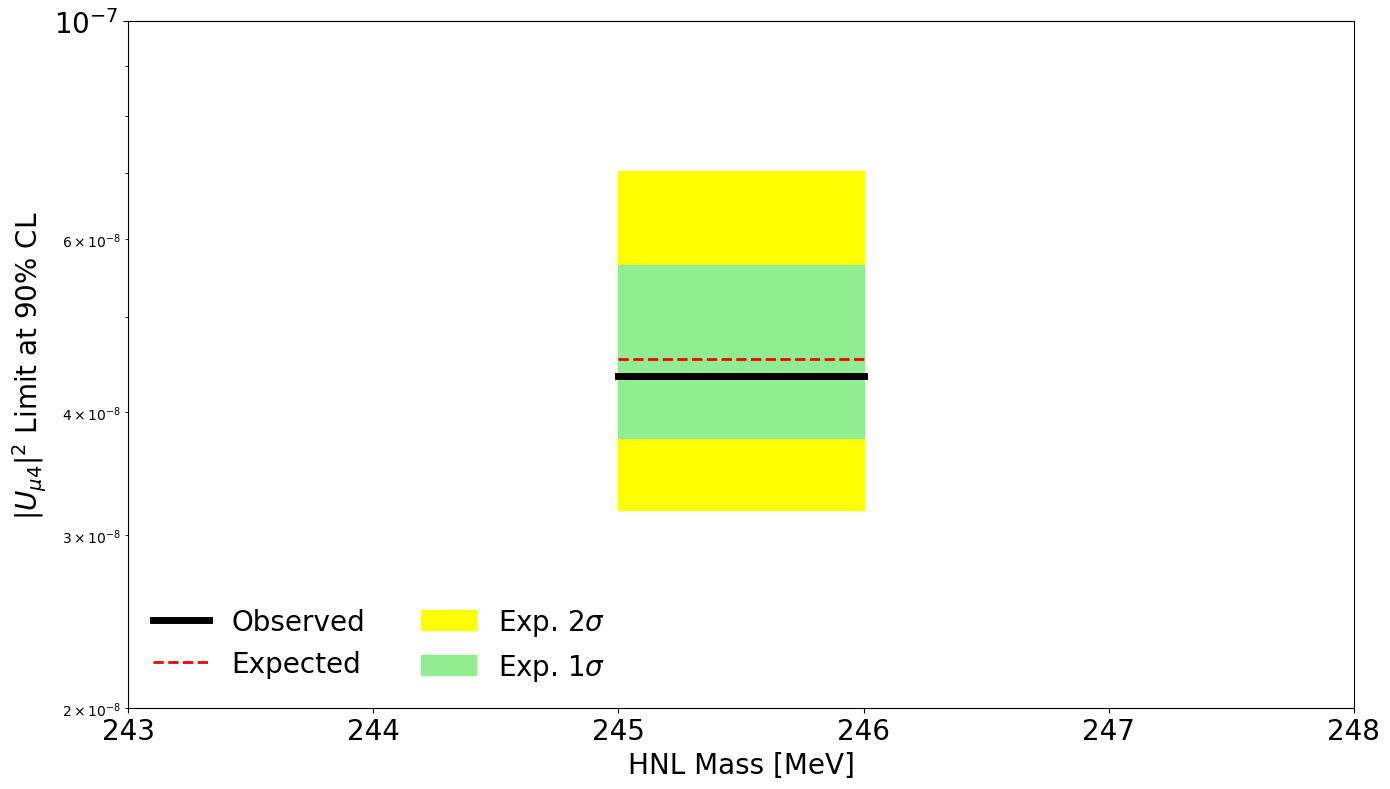

In [18]:
plt.figure(figsize=(14,8),facecolor='white',dpi=100)

savefig = True
# exp_limit = [] #entry 2
# exp_1sig_up = [] #entry 3
# exp_1sig_down = [] #entry 1
# exp_2sig_up = [] #entry 4
# exp_2sig_down = [] #entry 0

HNL_masses = [HNL_mass, 246]
# HNL_masses = Constants.HNL_mass_samples

plt.plot(HNL_masses,np.array(obs_limit),lw=5,ls='-',color='black',label='Observed')
plt.plot(HNL_masses,np.array(exp_limit),lw=2,ls='--',color='red',label='Expected')
plt.fill_between(HNL_masses,np.array(exp_2sig_down),np.array(exp_2sig_up),color='yellow',label=r'Exp. 2$\sigma$')
plt.fill_between(HNL_masses,np.array(exp_1sig_down),np.array(exp_1sig_up),color='lightgreen',label=r'Exp. 1$\sigma$')
# plt.fill_between(masses,m2s,p2s,color='lightgreen',label=r'Exp. 2$\sigma$')
# plt.grid(ls='--',color='C7',alpha=0.1)

plt.ylabel(r'$|U_{\mu 4}|^2$ Limit at 90% CL',fontsize=20)
plt.xlabel('HNL Mass [MeV]',fontsize=20)
# plt.title("HNL Mixing Upper Limit")
# plt.ylim(1e-8,1e-3)
plt.ylim(2e-8,1e-7)
plt.legend(loc="lower left",ncol=2,frameon=False,fontsize=20)
# plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=20,color='black',alpha=1,verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
# plt.xlim(0,250)
plt.xlim(243,248)
plt.yscale('log')
# plt.yscale('linear')
plt.tight_layout()

savename = "245_run1_observed"

if savefig == True:
    plt.savefig('plots/Limits/'+savename+'.pdf',bbox_inches='tight', pad_inches=0.3)

plt.grid(False)


## End of code

In [ ]:
print_vals = input("Do you want to run with new pois? y/n ")
if print_vals == "y":
    poi_new_dict = {}
    for HNL_mass in list_test:
        best_fit_value = exp_limits_dict[HNL_mass][2]
        new_poi_array = np.linspace(0.001, best_fit_value*2, 100)
        poi_new_dict[HNL_mass] = new_poi_array

    obs_limit_dict = {}
    exp_limits_dict = {}
    print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

    # for HNL_mass in Constants.HNL_mass_samples:
    for HNL_mass in list_test:

        obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
            DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_new_dict[HNL_mass], level=0.1, return_results=True
        )

        print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.4f}")
        print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.4f}" + "\n")

## Finished code

In [ ]:
# def New_BR_limit(Old_theta_squared, HNL_mass):
#     New_limit = Old_theta_squared*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
#     print("Old limit was " + str(Old_theta_squared))
#     print("New limit is " + str(New_limit))
#     return New_limit

# Old_limits = {20:0.00015681119188699395,
#               50:9.92373190724973e-06,
#               100:9.84200063077575e-07,
#               150:1.2830647341135436e-07,
#               180:7.604092480424186e-08}

In [ ]:
# New_limits = []
# for HNL_mass in list_test:
#     New_limits.append(New_BR_limit(Old_limits[HNL_mass], HNL_mass))
    
# r = zip([20,50,100,150,180], New_limits)

# with open(f'limit_files/New_BR_expected_mu.csv', "w") as s:
#     w = csv.writer(s)
#     for row in r:
#         w.writerow(row)

In [ ]:
# for HNL_mass in Constants.HNL_mass_samples:
#     new_scaling = np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
#     print("New scaling is " + str(new_scaling))


In [ ]:
print(Total_dict[20]["SIGNAL_ERR_dict"])

#print(Total_dict[20]["SIGNAL_dict"])

In [ ]:
TOTAL_SIGNAL_dict = {}
TOTAL_SIGNAL_ERR_dict = {}
TOTAL_BKG_dict = {}
TOTAL_BKG_ERR_dict = {}
TOTAL_DATA_dict = {}

for HNL_mass in HNL_masses:
    
    r1_signal = hist_dict_run1[HNL_mass]['signal']
    r1_EXT = hist_dict_run1[HNL_mass]['bkg_EXT']
    r1_nu = hist_dict_run1[HNL_mass]['bkg_overlay']
    r1_dirt = hist_dict_run1[HNL_mass]['bkg_dirt']
    r1_data = hist_dict_run1[HNL_mass]['data']
    
    r3_signal = hist_dict_run3[HNL_mass]['signal']
    r3_EXT = hist_dict_run3[HNL_mass]['bkg_EXT']
    r3_nu = hist_dict_run3[HNL_mass]['bkg_overlay']
    r3_dirt = hist_dict_run3[HNL_mass]['bkg_dirt']
    r3_data = hist_dict_run3[HNL_mass]['data']
    
    r1_bkg_hists = [r1_EXT, r1_nu, r1_dirt]
    r1_total_bkg = add_hists_vals(r1_bkg_hists)
    
    r3_bkg_hists = [r3_EXT, r3_nu, r3_dirt]
    r3_total_bkg = add_hists_vals(r3_bkg_hists)
    
    if Params_pyhf["Stats_only"] == True:
        overlay_r1_err = get_stat_errors(r1_nu)
        dirt_r1_err = get_stat_errors(r1_dirt)
        
        overlay_r3_err = get_stat_errors(r3_nu)
        dirt_r3_err = get_stat_errors(r3_dirt)
        
        r1_sig_err = get_stat_errors(r1_signal)
        r3_sig_err = get_stat_errors(r3_signal)
        
    elif Params_pyhf["Stats_only"] == False:
        overlay_r1_err = get_full_errors_nu_FLAT_INPUTS(r1_nu)
        dirt_r1_err = get_full_errors_dirt(r1_dirt)
      
        overlay_r3_err = get_full_errors_nu_FLAT_INPUTS(r3_nu)
        dirt_r3_err = get_full_errors_dirt(r3_dirt)
        
        r1_sig_err = get_full_errors_signal(r1_signal)
        r3_sig_err = get_full_errors_signal(r3_signal)
    
    
    r1_bkg_err_list = [overlay_r1_err, r1_EXT.errors(), dirt_r1_err]
    r1_total_bkg_err = add_all_errors(r1_bkg_err_list)

    r3_bkg_err_list = [overlay_r3_err, r3_EXT.errors(), dirt_r3_err]
    r3_total_bkg_err = add_all_errors(r3_bkg_err_list)
    
    #Converting np.ndarrays to lists
    SIGNAL_R1 = np.ndarray.tolist(r1_signal.values())
    SIGNAL_ERR_R1 = np.ndarray.tolist(r1_sig_err)
    BKG_R1 = np.ndarray.tolist(r1_total_bkg)
    BKG_ERR_R1 = np.ndarray.tolist(r1_total_bkg_err)
    DATA_R1 = np.ndarray.tolist(r1_data.values())
    
    SIGNAL_R3 = np.ndarray.tolist(r3_signal.values())
    SIGNAL_ERR_R3 = np.ndarray.tolist(r3_sig_err)
    BKG_R3 = np.ndarray.tolist(r3_total_bkg)
    BKG_ERR_R3 = np.ndarray.tolist(r3_total_bkg_err)
    DATA_R3 = np.ndarray.tolist(r3_data.values())
    
    list_of_lists = [SIGNAL_R1, SIGNAL_ERR_R1, BKG_R1, BKG_ERR_R1, DATA_R1, SIGNAL_R3, SIGNAL_ERR_R3, BKG_R3, BKG_ERR_R3, DATA_R3]
    if Params_pyhf["Use_second_half_only"] == True:
        for n in range(len(list_of_lists)):
            list_of_lists[n]=remove_first_half_hist(list_of_lists[n])
    
    TOTAL_SIGNAL_dict[HNL_mass] = append_r3_to_r1(list_of_lists[0], list_of_lists[5])
    TOTAL_SIGNAL_ERR_dict[HNL_mass] = append_r3_to_r1(list_of_lists[1], list_of_lists[6])
    TOTAL_BKG_dict[HNL_mass] = append_r3_to_r1(list_of_lists[2], list_of_lists[7])
    TOTAL_BKG_ERR_dict[HNL_mass] = append_r3_to_r1(list_of_lists[3], list_of_lists[8])
    TOTAL_DATA_dict[HNL_mass] = append_r3_to_r1(list_of_lists[4], list_of_lists[9])
    
    # print(f"Total {HNL_mass}MeV signal is ")
    # print(SIGNAL_R1)

# print()
# print("Total bkg is ")
# print(r1_total_bkg)

# print()
# print("Total bkg error is  ")
# print(r1_total_bkg_err)

In [ ]:
model_dict = {}
# for HNL_mass in HNL_masses:
#     model_dict[HNL_mass] = pyhf.simplemodels.uncorrelated_background(signal=TOTAL_SIGNAL_dict[HNL_mass],
#                                                                      bkg=TOTAL_BKG_dict[HNL_mass], 
#                                                                      bkg_uncertainty=TOTAL_BKG_ERR_dict[HNL_mass])
    
for HNL_mass in HNL_masses:
    model_dict[HNL_mass] = pyhf.Model(
        {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": TOTAL_SIGNAL_dict[HNL_mass],
          "modifiers": [
            {
              "name": "mu",
              "type": "normfactor",
              "data": None
            },
            {
              "name": "uncorr_siguncrt",
              "type": "shapesys",
              "data": TOTAL_SIGNAL_ERR_dict[HNL_mass]  
            }
          ]
        },
        {
          "name": "background",
          "data": TOTAL_BKG_dict[HNL_mass],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": TOTAL_BKG_ERR_dict[HNL_mass]
            }
          ]
        }
      ]
    }
  ]
}
)

In [ ]:
# model_full = pyhf.model.uncorrelated_background(signal=TOTAL_SIGNAL, signal_uncertainty=TOTAL_SIGNAL_ERR, bkg=TOTAL_BKG, bkg_uncertainty=TOTAL_BKG_ERR)
# model_full
# print(json.dumps(model.spec, indent=2))
# model.config.param_set("uncorr_bkguncrt").n_parameters
#model.config.param_set("uncorr_siguncrt").n_parameters

In [ ]:
#print(json.dumps(model.spec, indent=2))
DATA_OBS_dict = {}
for HNL_mass in HNL_masses:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only

    DATA_OBS_dict[HNL_mass] = TOTAL_DATA_dict[HNL_mass]+model_dict[HNL_mass].config.auxdata

    model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

In [ ]:
#pyhf.infer.mle.fit(data=DATA_OBS, pdf=model)
for HNL_mass in HNL_masses:
    CLs_obs, CLs_exp = pyhf.infer.hypotest(
        1.0,  # null hypothesis
        DATA_OBS_dict[HNL_mass],
        model_dict[HNL_mass],
        test_stat="qtilde",
        return_expected_set=True,
        )
    
#print(f"      Observed CLs: {CLs_obs:.4f}")
    print(f"{HNL_mass}MeV")
    for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
        print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

In [ ]:
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

for HNL_mass in HNL_masses:

    poi_values = np.linspace(0.001, 10, 100)
    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=0.1, return_results=True
    )
    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.4f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.4f}" + "\n")

In [ ]:
with open('bdt_output/new_theta_dict.pkl', 'rb') as handle:
    new_theta_dict = pickle.load(handle)
print(new_theta_dict)

In [ ]:
#Mass point
with open('bdt_output/new_theta_dict.pkl', 'rb') as handle:
    new_theta_dict = pickle.load(handle)
#print(new_theta_dict)
scaled_thetas = new_theta_dict #Saved in 3.5_BDT_Result

exp_limit = []
obs_limit = []

for HNL_mass in HNL_masses:
    theta_squared = (scaled_thetas[HNL_mass])**2

    EXP_LIMIT = np.sqrt(exp_limits_dict[HNL_mass][2])*theta_squared
    LIMIT = np.sqrt(obs_limit_dict[HNL_mass])*theta_squared
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)
# print()
# print("Owen's expected limit is " + str(Owen_exp_limit))
# print("Owen's observed limit is " + str(Owen_obs_limit))

# print()
# perc_diff_exp = (1-(EXP_LIMIT/Owen_exp_limit))*100
# perc_diff_obs = (1-(LIMIT/Owen_obs_limit))*100

# print("pyhf expected limit is " + str(perc_diff_exp) + " different from Owen's limit.")
# print("pyhf observed limit is " + str(perc_diff_obs) + " different from Owen's limit.")

## Saving Limits as .csv

In [ ]:
masses = HNL_masses

if Params_pyhf["Stats_only"] == True:
    stats =  "Stats_only"
else:
    stats = "Owen_sys"
    
if Params_pyhf["Use_second_half_only"] == True:
    half_hist = "havled"
else:
    half_hist = "full_hist"

print(masses)
print(exp_limit)

r = zip(masses, exp_limit)

with open(f'limit_files/{stats}_{half_hist}_expected_mu_COMBINED_highest_E.csv', "w") as s:
    w = csv.writer(s)
    for row in r:
        w.writerow(row)


In [ ]:
HNL_mass = 100
print(json.dumps(model_dict[HNL_mass].spec, indent=2))

In [ ]:
model_dict_full_sys = {}

for HNL_mass in HNL_masses:
    model_dict_full_sys[HNL_mass] = pyhf.Model(
        {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": TOTAL_SIGNAL_dict[HNL_mass],
          "modifiers": [
            {
              "name": "mu",
              "type": "normfactor",
              "data": None
            },
            {
              "name": "uncorr_siguncrt",
              "type": "shapesys",
              "data": TOTAL_SIGNAL_ERR_dict[HNL_mass]  
            }
          ]
        },
        {
          "name": "background",
          "data": TOTAL_BKG_dict[HNL_mass],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": TOTAL_BKG_ERR_dict[HNL_mass]
            }
          ]
        }
      ]
    }
  ]
}
)


# Adding in signal systematic uncertainty

In [ ]:
#Messing around with model

full_model = pyhf.Model(
    {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": [
            0.4354482889175415,
            0.6531724333763123,
            0.9367626905441284,
            1.1947383880615234,
            1.3539148569107056,
            1.192908763885498,
            0.6879351139068604,
            0.2671237289905548,
            0.8156560063362122,
            1.649437665939331,
            2.6418192386627197,
            3.511852264404297,
            3.4166924953460693,
            2.6418192386627197,
            1.114729881286621,
            0.842844545841217
          ],
          "modifiers": [
            {
              "name": "mu",
              "type": "normfactor",
              "data": None
            },
            {
              "name": "uncorr_siguncrt",
              "type": "shapesys",
              "data": TOTAL_SIGNAL_ERR  
            }
          ]
        },
        {
          "name": "background",
          "data": [
            227.98190307617188,
            185.65267944335938,
            141.53671264648438,
            83.10063171386719,
            39.49835968017578,
            20.065095901489258,
            5.26054573059082,
            0.7651026844978333,
            385.53765869140625,
            330.3393249511719,
            241.39376831054688,
            143.0430908203125,
            55.337371826171875,
            20.656126022338867,
            7.634726524353027,
            3.049088954925537
          ],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": [
                34.158817291259766,
                27.066844940185547,
                22.60236358642578,
                14.79345417022705,
                6.955612659454346,
                4.61644983291626,
                1.6257153749465942,
                0.48608535528182983,
                73.31805419921875,
                65.45207214355469,
                51.50766372680664,
                34.320030212402344,
                10.886519432067871,
                5.264797210693359,
                2.1698012351989746,
                1.1060731410980225
              ]
            }
          ]
        }
      ]
    }
  ]
}
)

In [ ]:
#print(json.dumps(full_model.spec, indent=2))
init_pars = full_model.config.suggested_init()
full_model.expected_actualdata(init_pars) #signal plus bkg

bkg_pars = init_pars.copy()
bkg_pars[model.config.poi_index] = 0
full_model.expected_actualdata(bkg_pars) #bkg only

DATA_OBS = TOTAL_DATA+full_model.config.auxdata

full_model.logpdf(pars=bkg_pars, data=DATA_OBS)

In [ ]:
CLs_obs, CLs_exp = pyhf.infer.hypotest(
    1.0,  # null hypothesis
    DATA_OBS,
    full_model,
    test_stat="qtilde",
    return_expected_set=True,
)
print(f"      Observed CLs: {CLs_obs:.4f}")
for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
    print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

In [ ]:
poi_values = np.linspace(0.1, 10, 50)
obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upperlimit(
    DATA_OBS, full_model, poi_values, level=0.1, return_results=True
)
print(f"Upper limit (obs): μ = {obs_limit:.4f}")
print(f"Upper limit (exp): μ = {exp_limits[2]:.4f}")

In [ ]:
#Mass point
EXP_LIMIT = np.sqrt(exp_limits[2])*theta_squared
LIMIT = np.sqrt(obs_limit)*theta_squared
print("Expected limit is " + str(EXP_LIMIT))
print("Observed limit is " + str(LIMIT))
print()
print("Owen's expected limit is " + str(Owen_exp_limit))
print("Owen's observed limit is " + str(Owen_obs_limit))

print()
perc_diff_exp = (1-(EXP_LIMIT/Owen_exp_limit))*100
perc_diff_obs = (1-(LIMIT/Owen_obs_limit))*100

# perc_diff_exp = (1-(Owen_exp_limit/EXP_LIMIT))*100
# perc_diff_obs = (1-(Owen_obs_limit/LIMIT))*100

print("pyhf expected limit is " + str(perc_diff_exp) + "% different from Owen's limit.")
print("pyhf observed limit is " + str(perc_diff_obs) + "% different from Owen's limit.")